In [ ]:
#https://www.kaggle.com/code/ddayanavincent/sam-segment-anything-on-a-custom-dataset/notebook

# Data

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
#kaggle api username and key: {"username":"meganrottkamp","key":"ed76fd6e08cc1d607845adb45d15a37f"}
#kaggle dataset: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/code?datasetId=1209633

#download data using kaggle api
od.download("https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/code?datasetId=1209633")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: meganrottkamp
Your Kaggle Key: ··········


100%|██████████| 195M/195M [00:01<00:00, 169MB/s]


In [4]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets
!pip install -q monai

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00


In [5]:
# Importing Libraries

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import re
import requests
import random


# SAM


Create a dataset that is in the proper format for the model. It requires the image (pixel values), a prompt in the form of a bounding box and a ground truth segmentation mask.

In [6]:
# Indexing Function

def num (image) :
    val = 0
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    return val

label2id = dict({
    'benign': 0,
    'malignant': 1,
    'normal': 2
})

id2label = {
    0: 'benign',
    1: 'malignant',
    2: 'normal'
}

print(id2label[0])
print(label2id['normal'])

benign
2


In [7]:
# separate the images into masked and unmasked
masked_images = glob.glob("/content/breast-ultrasound-images-dataset/*/*/*_mask*")
non_masked_images = [file for file in glob.glob(os.path.join("/content/breast-ultrasound-images-dataset/*/*", '*')) if 'mask' not in file]

id_list = []
img_list = []
mask_list = []
label_list = []

non_masked_images.sort()
masked_images.sort()

count = len(non_masked_images)
i = 0
desired_size = (256, 256)

while i < count:
    img = non_masked_images[i]
    image_name = img.split('/')[-1].split(')')[0] + ')'
    # ID
    id = str(image_name[0]) + str(num(image_name))
    # Label
    label = img.split('/')[-2]
    if label != 'normal':
        id_list.append(id)
        label_list.append(label2id[label])
        # Image
        image = cv2.imread(img, cv2.IMREAD_UNCHANGED)
        resized_img = cv2.resize(image, desired_size, interpolation = cv2.INTER_NEAREST)
        img_list.append(Image.fromarray(resized_img))
        # Mask
        r = re.compile(r".*"+re.escape(image_name)) # look for mask
        masks = list(filter(r.match, masked_images))
        mask = None
        for m in masks:
          if mask is None:
            mask =  cv2.imread(m)
          else:
            extr_mask = cv2.imread(m)
            mask = cv2.bitwise_or(mask, extr_mask)
        resized_mask = cv2.resize(mask, desired_size, interpolation = cv2.INTER_NEAREST)
        # print("last mask: ", np.unique(resized_mask))
        mask_list.append((Image.fromarray(resized_mask)).convert('I'))
        # masked_images = masked_images[len(masks):]

    i += 1

In [8]:
from datasets import Dataset, Image

def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

dataset = create_dataset(images = img_list, labels = mask_list)
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 647
})

In [9]:
dataset[5]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': <PIL.TiffImagePlugin.TiffImageFile image mode=I size=256x256>}

In [10]:
# from sklearn.preprocessing import Binarizer

image = dataset[5]["label"]

ground_truth_seg = np.array(image)
# ground_truth_seg = (np.where(ground_truth_seg > 0.5, 1, 0)).astype(np.int32)
# ground_truth_mask = np.array(item["label"].convert('1')).astype(np.int32)

print(ground_truth_seg)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
np.unique(ground_truth_seg)

array([  0, 255], dtype=int32)

In [12]:
# normalize to the range 0-1

# binary_mask = np.where(img_array > 128, 1, 0)
ground_truth_seg = (ground_truth_seg / 255).astype('int32')
np.unique(ground_truth_seg)

array([0, 1], dtype=int32)

(256, 256)


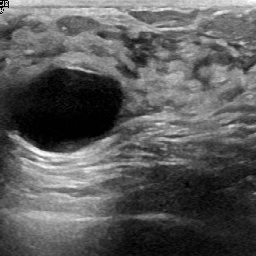

In [13]:
print(dataset[5]["image"].size)
dataset[5]["image"]

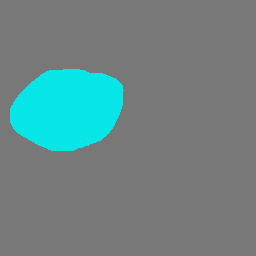

In [14]:
from PIL import Image

# a random color palette mapping each class to a color (RGB)
palette = [[120, 120, 120], [6, 230, 230]]

color_seg = np.zeros((ground_truth_seg.shape[0], ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3

for label, color in enumerate(palette):
    color_seg[ground_truth_seg == label, :] = color

Image.fromarray(color_seg)

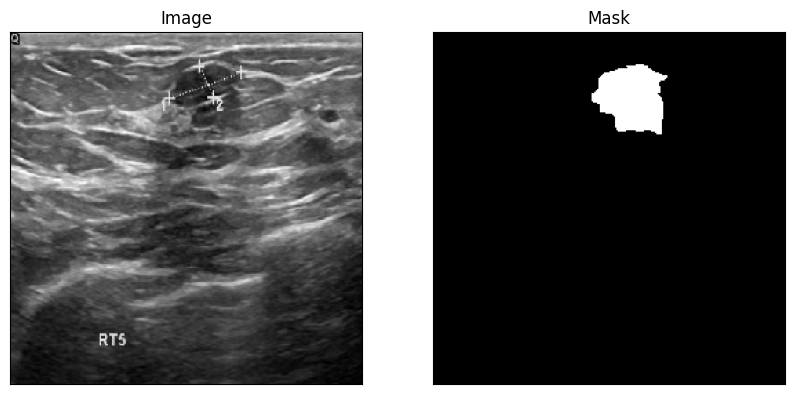

In [15]:
img_num = random.randint(0, dataset.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [16]:
splits = dataset.train_test_split(test_size=0.05, shuffle=True)
splits

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 614
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 33
    })
})

In [17]:
# split up training into training + test
train_ds = splits['train']
test_ds = splits['test']

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]

    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


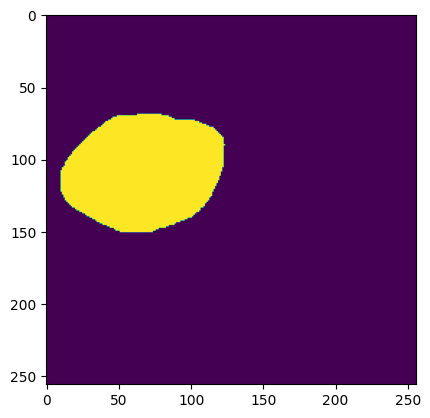

In [19]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))

#ground_truth_seg = np.array(example["label"])
ground_truth_seg = np.array(image)
#ground_truth_seg = np.array([[example["label"]]])
#ground_truth_seg = np.array([[0]])

In [20]:

show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

In [21]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [22]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [23]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [24]:
train_dataset = SAMDataset(dataset=train_ds, processor=processor)


In [25]:
example = train_dataset[0]

for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [27]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [28]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [29]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

Training the Model

In [30]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [31]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 307/307 [05:22<00:00,  1.05s/it]


EPOCH: 0
Mean loss: -49999.721291396054


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 1
Mean loss: -214520.32829041124


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 2
Mean loss: -419931.93837795197


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 3
Mean loss: -710751.9489642712


100%|██████████| 307/307 [05:22<00:00,  1.05s/it]


EPOCH: 4
Mean loss: -1121513.155817386


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 5
Mean loss: -1680689.0298503665


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 6
Mean loss: -2432392.3945948696


100%|██████████| 307/307 [05:22<00:00,  1.05s/it]


EPOCH: 7
Mean loss: -3403384.544024837


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 8
Mean loss: -4644882.1439332245


100%|██████████| 307/307 [05:22<00:00,  1.05s/it]


EPOCH: 9
Mean loss: -6191041.285321661


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 10
Mean loss: -8078612.195948697


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 11
Mean loss: -10363097.645154724


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 12
Mean loss: -13071552.679967428


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 13
Mean loss: -16238156.354641695


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 14
Mean loss: -19864819.118078176


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 15
Mean loss: -23977543.322068404


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 16
Mean loss: -28631059.331433225


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 17
Mean loss: -33859726.50651466


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]


EPOCH: 18
Mean loss: -39713391.47557003


100%|██████████| 307/307 [05:21<00:00,  1.05s/it]

EPOCH: 19
Mean loss: -46228561.048045605


In [32]:
#inference

import numpy as np
from PIL import Image

In [33]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

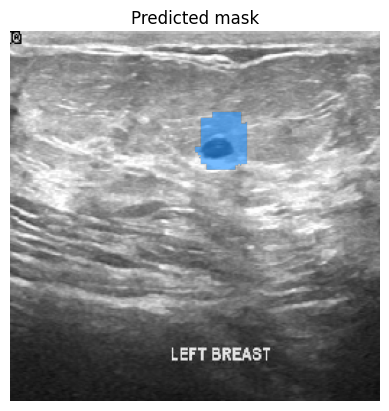

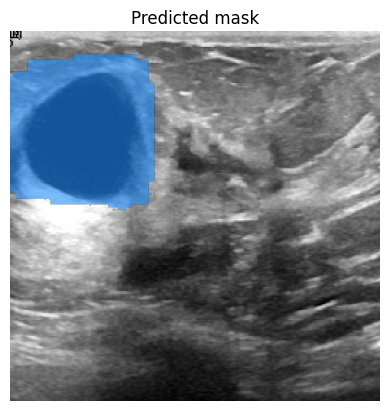

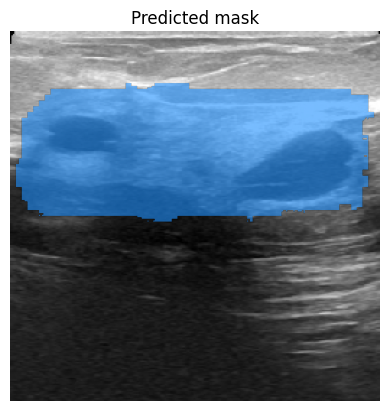

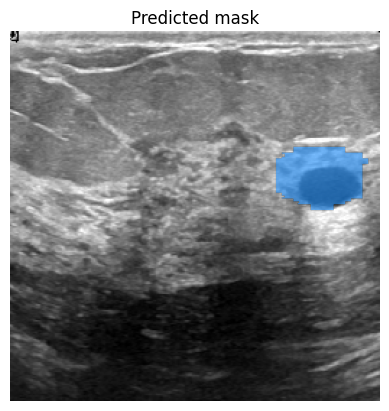

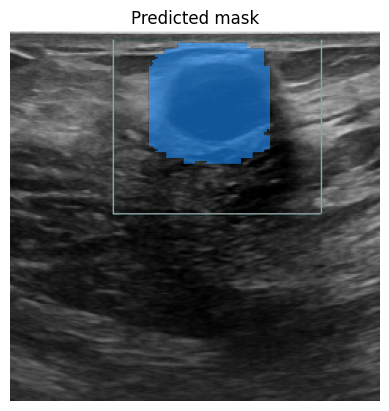

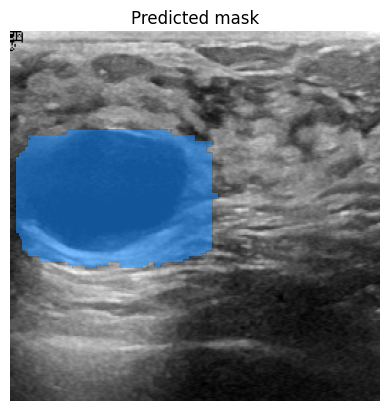

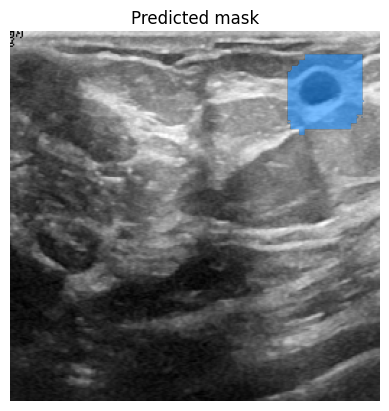

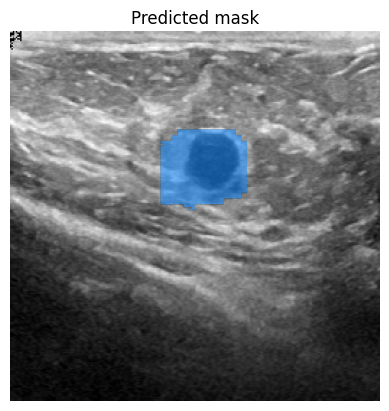

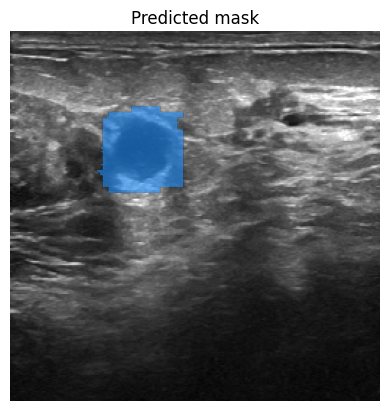

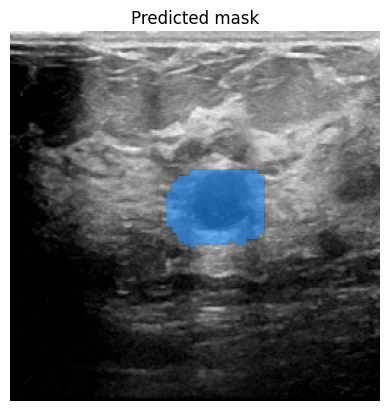

In [35]:
for i in range(10):
  idx = i
  image = dataset[idx]["image"]

  # get box prompt based on ground truth segmentation map
  ground_truth_mask = np.array(dataset[idx]["label"])
  prompt = get_bounding_box(ground_truth_mask)

  # prepare image + box prompt for the model
  inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

  model.eval()

  # forward pass
  with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

  # apply sigmoid
  medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
  medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

  fig, axes = plt.subplots()

  axes.imshow(np.array(image))
  show_mask(medsam_seg, axes)
  axes.title.set_text(f"Predicted mask")
  axes.axis("off")


  #fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  #axes[0].imshow(np.array(image), cmap='gray')
  #axes[0].set_title("Original Image")

  #axes[1].imshow(medsam_seg, cmap='gray')
  #axes[1].set_title("Masked Image")

  #for ax in axes:
  #  ax.set_xticks([])
  #  ax.set_yticks([])
  #  ax.set_xticklabels([])
  #  ax.set_yticklabels([])
  # Display the images side by side
  #plt.show()

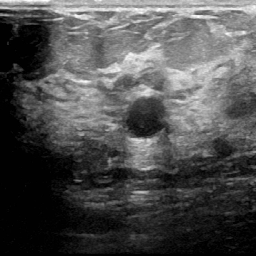

In [ ]:
# # take a random training example
# #idx = 9

# # load image
# image = dataset[idx]["image"]
# image

# # get box prompt based on ground truth segmentation map
# ground_truth_mask = np.array(dataset[idx]["label"])
# prompt = get_bounding_box(ground_truth_mask)

# # prepare image + box prompt for the model
# inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
# for k,v in inputs.items():
#   print(k,v.shape)

# model.eval()

# # forward pass
# with torch.no_grad():
#   outputs = model(**inputs, multimask_output=False)

# # apply sigmoid
# medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# # convert soft mask to hard mask
# medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
# medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

# def show_mask(mask, ax, random_color=False):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     ax.imshow(mask_image)



# fig, axes = plt.subplots()

# axes.imshow(np.array(image))
# show_mask(medsam_seg, axes)
# axes.title.set_text(f"Predicted mask")
# axes.axis("off")